In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy
import spacy
from nltk.corpus import stopwords
from collections import Counter
%matplotlib inline
sns.set_style("darkgrid")
colors = ['#651FFF', '#00B0FF', '#1DE9B6', '#00E676', '#FF9100', '#FF3D00']
sns.set_palette(colors)

In [2]:
bus = pd.read_csv('data/mta_1706.csv', low_memory=False)

bus.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
0,6/1/17 0:03,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,40.635170,-73.960803,FOSTER AV/E 18 ST,approaching,76,6/1/17 0:03,24:06:14
1,6/1/17 0:03,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,40.590802,-74.158340,MERRYMOUNT ST/TRAVIS AV,approaching,62,6/1/17 0:03,23:58:02
2,6/1/17 0:03,0,Bx10,E 206 ST/BAINBRIDGE AV,40.875008,-73.880142,RIVERDALE 263 ST,40.912376,-73.902534,NYCT_4223,40.886010,-73.912647,HENRY HUDSON PKY E/W 235 ST,at stop,5,6/1/17 0:03,24:00:53
3,6/1/17 0:03,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,40.668002,-73.729348,HOOK CREEK BL/SUNRISE HY,< 1 stop away,267,6/1/17 0:04,24:03:00
4,6/1/17 0:03,1,Bx1,RIVERDALE AV/W 231 ST,40.881187,-73.909340,MOTT HAVEN 136 ST via CONCOURSE,40.809654,-73.928360,NYCT_4710,40.868134,-73.893032,GRAND CONCOURSE/E 196 ST,at stop,11,6/1/17 0:03,23:59:38


In [3]:
nullvals = pd.DataFrame(bus.isna().sum())
nullvals

,0
RecordedAtTime,0
DirectionRef,0
PublishedLineName,0
OriginName,8463
OriginLat,8463
OriginLong,8463
DestinationName,0
DestinationLat,1246
DestinationLong,1246
VehicleRef,0


In [4]:
bus = bus.dropna()

In [5]:
bus['RecordedAtTime'] = pd.to_datetime(bus['RecordedAtTime'])

In [6]:
bus['day_of_week'] = bus['RecordedAtTime'].dt.dayofweek

In [7]:
bus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 923994 entries, 0 to 1048573
Data columns (total 18 columns):
RecordedAtTime               923994 non-null datetime64[ns]
DirectionRef                 923994 non-null int64
PublishedLineName            923994 non-null object
OriginName                   923994 non-null object
OriginLat                    923994 non-null float64
OriginLong                   923994 non-null float64
DestinationName              923994 non-null object
DestinationLat               923994 non-null float64
DestinationLong              923994 non-null float64
VehicleRef                   923994 non-null object
VehicleLocation.Latitude     923994 non-null float64
VehicleLocation.Longitude    923994 non-null float64
NextStopPointName            923994 non-null object
ArrivalProximityText         923994 non-null object
DistanceFromStop             923994 non-null object
ExpectedArrivalTime          923994 non-null object
ScheduledArrivalTime         923994 non-nul

In [8]:
# DONT RUN THIS TWICE, WILL BREAK THE TIME
bus['ExpectedArrivalTime'] = pd.to_datetime(bus['ExpectedArrivalTime'], errors='coerce', utc=True)
bus['ExpectedArrivalTime'].head()

bus['ExpectedArrivalTime'] = pd.to_datetime(bus['ExpectedArrivalTime'], errors='coerce', utc=True)
sch_hours = pd.DataFrame()
sch_hours['hour'] = bus['ExpectedArrivalTime'].dt.hour
sch_hours['min'] = bus['ExpectedArrivalTime'].dt.minute

sch_hours['time'] = sch_hours['hour'].astype(str).str.cat(sch_hours['min'].astype(str))
sch_hours['time'] = sch_hours['time'].str.replace('.0','')
sch_hours['time'] = pd.to_numeric(sch_hours['time'], errors='coerce')

In [9]:
bus['ExpectedArrivalTime'] = sch_hours['time']

In [10]:
# DONT RUN THIS TWICE, WILL BREAK THE TIME
bus['ScheduledArrivalTime'] = pd.to_datetime(bus['ScheduledArrivalTime'], errors='coerce', utc=True)
sch_hours2 = pd.DataFrame()
sch_hours2['hour'] = bus['ScheduledArrivalTime'].dt.hour
sch_hours2['min'] = bus['ScheduledArrivalTime'].dt.minute

sch_hours2['time'] = sch_hours2['hour'].astype(str).str.cat(sch_hours2['min'].astype(str))
sch_hours2['time'] = sch_hours2['time'].str.replace('.0','')
sch_hours2['time'] = pd.to_numeric(sch_hours2['time'], errors='coerce')

In [11]:
bus['ScheduledArrivalTime'] = sch_hours2['time']

In [12]:
bus[['ScheduledArrivalTime','ExpectedArrivalTime']].tail(10)

,ScheduledArrivalTime,ExpectedArrivalTime
1048562,211.0,212.0
1048563,211.0,213.0
1048564,212.0,213.0
1048565,213.0,212.0
1048566,214.0,212.0
1048567,219.0,212.0
1048568,214.0,213.0
1048569,57.0,214.0
1048571,59.0,212.0
1048573,212.0,213.0


In [13]:
bus = bus.dropna()
bus['delay'] = bus['ScheduledArrivalTime'] - bus['ExpectedArrivalTime']

bus[['ScheduledArrivalTime', 'ExpectedArrivalTime', 'delay']].head(10)

,ScheduledArrivalTime,ExpectedArrivalTime,delay
1,2358.0,3.0,2355.0
4,2359.0,3.0,2356.0
7,2358.0,4.0,2354.0
10,2348.0,4.0,2344.0
19,2346.0,4.0,2342.0
22,2355.0,4.0,2351.0
27,2357.0,3.0,2354.0
29,2352.0,4.0,2348.0
30,2358.0,4.0,2354.0
34,2359.0,3.0,2356.0


In [14]:
bus.delay.loc[bus.delay>120] = 2360 - bus.delay.loc[bus.delay>120]

bus[['ScheduledArrivalTime', 'ExpectedArrivalTime', 'delay']].head(20)

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,ScheduledArrivalTime,ExpectedArrivalTime,delay
1,2358.0,3.0,5.0
4,2359.0,3.0,4.0
7,2358.0,4.0,6.0
10,2348.0,4.0,16.0
19,2346.0,4.0,18.0
22,2355.0,4.0,9.0
27,2357.0,3.0,6.0
29,2352.0,4.0,12.0
30,2358.0,4.0,6.0
34,2359.0,3.0,4.0


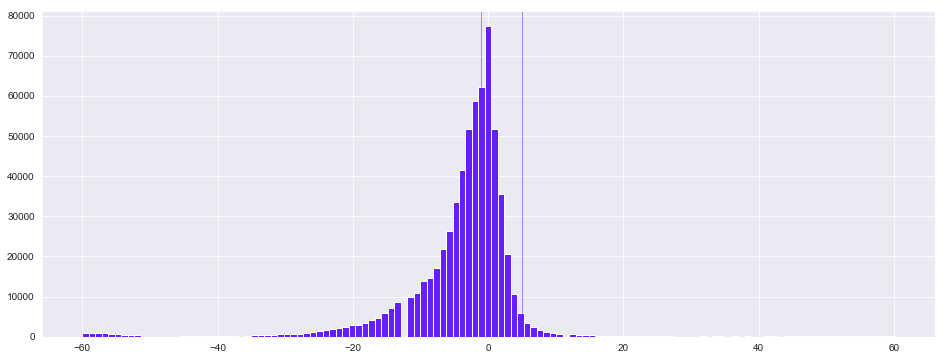

In [15]:
#bus.delay.loc[bus.delay<-120] = 2360 + bus.delay.loc[bus.delay<-120]
bus = bus.drop(bus[bus['delay']>60].index)
bus = bus.drop(bus[bus['delay']<-60].index)
plt.figure(figsize=(16,6))
plt.hist(bus['delay'], bins=125)
plt.axvline(x=5, linewidth=.5)
plt.axvline(x=-1, linewidth=.5)
plt.show()

In [16]:
bus.loc[bus.delay<-10].head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,day_of_week,delay
979,2017-06-01 00:13:00,0,X1,ELTINGVILLE/TRANSIT CENTER,40.560760,-74.171089,W MDTWN CNTRL PK S. via CHURCH via 6 AV,40.766006,-73.976807,NYCT_2513,40.543925,-74.144359,HYLAN BL/HILLSIDE TER,< 1 stop away,250,14.0,0.0,3,-14.0
1111,2017-06-01 00:13:00,1,B62,JACKSON AV/QUEENS PZ S,40.748638,-73.938446,DOWNTOWN BKLYN FULTON MALL,40.690407,-73.989471,NYCT_4449,40.726830,-73.952532,MANHATTAN AV/MESEROLE AV,at stop,5,13.0,0.0,3,-13.0
1153,2017-06-01 00:13:00,1,Bx27,MORRISON AV/WESTCHESTER AV,40.829098,-73.874573,CLASON PT,40.807545,-73.852341,NYCT_321,40.813149,-73.857499,SOUNDVIEW AV/OBRIEN AV,< 1 stop away,211,14.0,0.0,3,-14.0
1154,2017-06-01 00:13:00,1,Bx27,MORRISON AV/WESTCHESTER AV,40.829098,-73.874573,CLASON PT,40.807545,-73.852341,NYCT_321,40.813149,-73.857499,SOUNDVIEW AV/OBRIEN AV,< 1 stop away,211,14.0,0.0,3,-14.0
1762,2017-06-01 00:23:00,1,B62,JACKSON AV/QUEENS PZ S,40.748638,-73.938446,DOWNTOWN BKLYN FULTON MALL,40.690407,-73.989471,NYCT_4449,40.707548,-73.961392,DIVISION AV/DRIGGS AV,approaching,70,23.0,0.0,3,-23.0


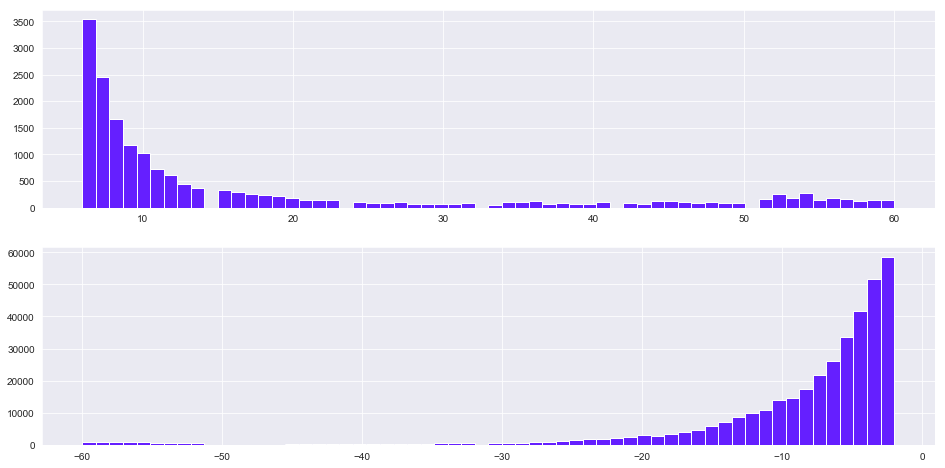

In [17]:
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
bus.delay.loc[bus.delay>5].hist(bins=60)
plt.subplot(2,1,2)
bus.delay.loc[bus.delay<-1].hist(bins=60)
plt.show()

According to this document, an on-time bus is defined as either more than 1 minute early and 5 minutes late.  https://docs.google.com/spreadsheets/d/1WqLV3EeCMOZwi0oZdYICkuvN86N0S4QGTMvbhS8UU0E/edit#gid=0

In [18]:
# https://docs.google.com/spreadsheets/d/1WqLV3EeCMOZwi0oZdYICkuvN86N0S4QGTMvbhS8UU0E/edit#gid=0
bus['on_time'] = np.where((bus['delay'] > 5) | (bus['delay'] < -1), 0, 1)
bus.head(3)

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,day_of_week,delay,on_time
1,2017-06-01 00:03:00,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,40.590802,-74.158340,MERRYMOUNT ST/TRAVIS AV,approaching,62,3.0,2358.0,3,5.0,1
4,2017-06-01 00:03:00,1,Bx1,RIVERDALE AV/W 231 ST,40.881187,-73.909340,MOTT HAVEN 136 ST via CONCOURSE,40.809654,-73.928360,NYCT_4710,40.868134,-73.893032,GRAND CONCOURSE/E 196 ST,at stop,11,3.0,2359.0,3,4.0,1
7,2017-06-01 00:03:00,0,B83,GATEWAY CTR TERM/GATEWAY DR,40.652649,-73.877029,BWAY JCT VN SNDRN AV,40.678139,-73.903572,NYCT_4841,40.648801,-73.882682,PENNSYLVANIA AV/DELMAR LOOP N,< 1 stop away,196,4.0,2358.0,3,6.0,0


In [19]:
bus['PublishedLineName'].head(10)

1      S61
4      Bx1
7      B83
10    Bx28
19     Q54
22    M101
27     M11
29      M2
30     B41
34    Bx32
Name: PublishedLineName, dtype: object

In [20]:
bronx = bus['PublishedLineName'].str.startswith('Bx')
manhattan = bus['PublishedLineName'].str.contains('M')
brooklyn = bus['PublishedLineName'].str.startswith('B')
queens = bus['PublishedLineName'].str.startswith('Q')
staten = bus['PublishedLineName'].str.startswith('S')
express = bus['PublishedLineName'].str.startswith('X')
select = bus['PublishedLineName'].str.contains('SBS')

In [21]:
bus['boro'] = np.where(bronx, '2 - bronx',
                       np.where(manhattan, '3 - manhattan',
                                np.where(brooklyn, '1 - brooklyn',
                                         np.where(queens, '4 - queens',
                                                  np.where(staten, '5 - staten island',
                                                           np.where(express, 'x-express',
                                                           bus['PublishedLineName'].str.replace('-', ' ')))))))
#bus['boro'] = bus['boro'].astype('category')

In [22]:
bus['boro'] = bus['boro'].astype('category')
dict(enumerate(bus['boro'].cat.categories))

{0: '1 - brooklyn',
 1: '2 - bronx',
 2: '3 - manhattan',
 3: '4 - queens',
 4: '5 - staten island',
 5: 'x-express'}

In [23]:
bus['boro_code'] = bus['boro'].cat.codes

In [24]:
bus['express'] = np.where(express, 1, 0)
bus['sbs'] = np.where(select, 1, 0)
bus.head(2)

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,day_of_week,delay,on_time,boro,boro_code,express,sbs
1,2017-06-01 00:03:00,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,...,62,3.0,2358.0,3,5.0,1,5 - staten island,4,0,0
4,2017-06-01 00:03:00,1,Bx1,RIVERDALE AV/W 231 ST,40.881187,-73.909340,MOTT HAVEN 136 ST via CONCOURSE,40.809654,-73.928360,NYCT_4710,...,11,3.0,2359.0,3,4.0,1,2 - bronx,1,0,0


In [25]:
bus['PublishedLineName'] = bus['PublishedLineName'].astype('category')
bus['bus_code'] = bus['PublishedLineName'].cat.codes
bus_codes = dict(enumerate(bus['PublishedLineName'].cat.categories))

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


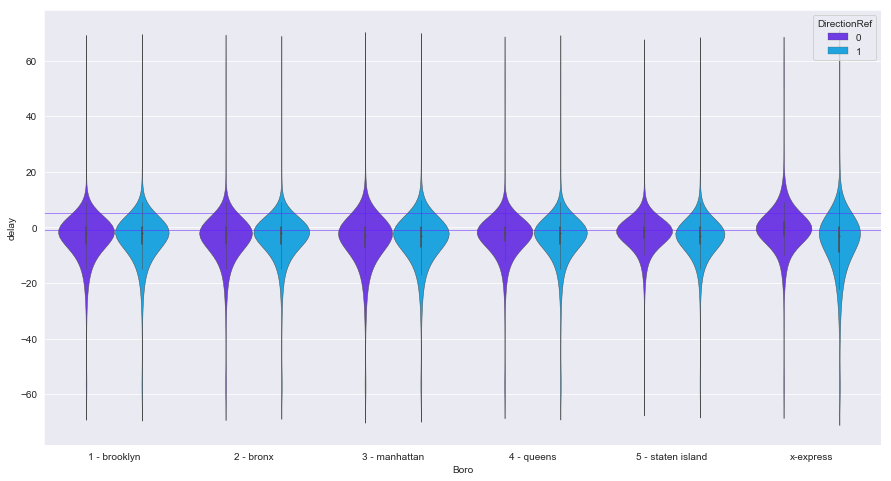

In [26]:
plt.figure(figsize=(15,8))
sns.violinplot(x='boro', y='delay', hue='DirectionRef', data=bus, linewidth=.5, bw=.5)
plt.xlabel('Boro')
plt.axhline(y=5, linewidth=.5)
plt.axhline(y=-1, linewidth=.5)
plt.show()

In [27]:
bus['date'] = bus['RecordedAtTime'].dt.date

In [28]:
bus['date'].value_counts()

2017-06-02    169319
2017-06-01    166470
2017-06-05    124297
2017-06-03    115589
2017-06-04     70868
Name: date, dtype: int64

In [29]:
bus.ArrivalProximityText.value_counts().head(10)

approaching       251301
< 1 stop away     217109
at stop           157474
0.6 miles away      4058
0.5 miles away      2795
0.7 miles away      2352
0.8 miles away      1387
0.9 miles away      1127
1.0 miles away       881
1.1 miles away       571
Name: ArrivalProximityText, dtype: int64

In [30]:
bus.columns

Index(['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation.Latitude',
       'VehicleLocation.Longitude', 'NextStopPointName',
       'ArrivalProximityText', 'DistanceFromStop', 'ExpectedArrivalTime',
       'ScheduledArrivalTime', 'day_of_week', 'delay', 'on_time', 'boro',
       'boro_code', 'express', 'sbs', 'bus_code', 'date'],
      dtype='object')

In [31]:
bus['day_of_week']

bus.day_of_week.value_counts()

4    169319
3    166470
0    124297
5    115589
6     70868
Name: day_of_week, dtype: int64

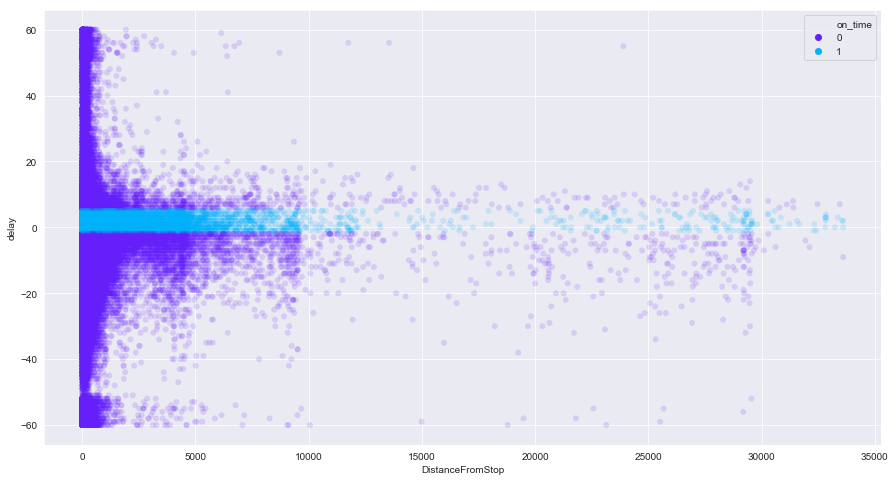

In [32]:
bus["DistanceFromStop"] = pd.to_numeric(bus["DistanceFromStop"])
plt.figure(figsize=(15,8))
sns.scatterplot(x="DistanceFromStop", y="delay", hue='on_time',
                linewidth=0, data=bus, alpha=.15)
plt.show()

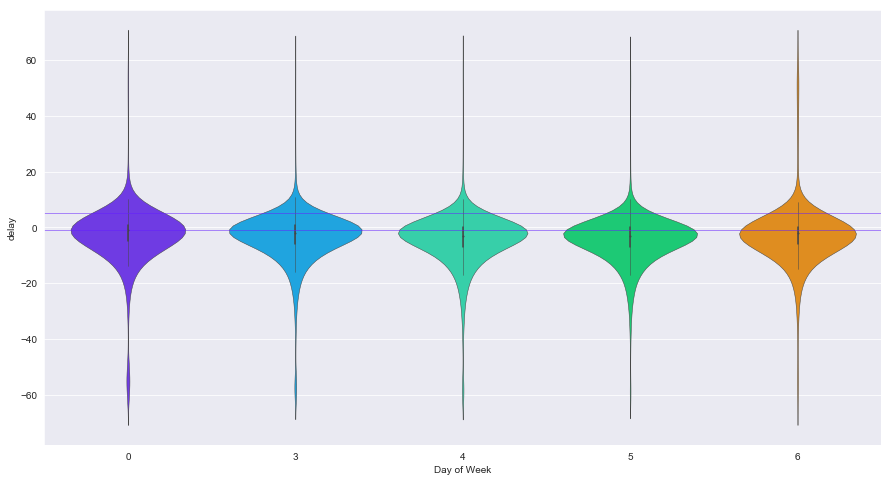

In [33]:
plt.figure(figsize=(15,8))
sns.violinplot(x='day_of_week', y='delay', data=bus, linewidth=.5, bw=.5)
plt.xlabel('Day of Week')
plt.axhline(y=5, linewidth=.5)
plt.axhline(y=-1, linewidth=.5)
plt.show()

In [34]:
#seller = mel_raw.groupby('SellerG')['Price'].nunique().sort_values(ascending=False).head(40)
seller_plt = pd.DataFrame(bus[['PublishedLineName','delay', 'on_time']].groupby('PublishedLineName')['delay'].mean().sort_values(ascending=False))
seller_plt.reset_index(level=0, inplace=True)
seller_plt.sort_values(by='delay', ascending=True).head(10)


,PublishedLineName,delay
235,S86,-14.535714
234,S84,-10.090090
233,Q56,-7.629262
232,Q32,-7.191506
231,M7,-7.150430
230,Bx32,-7.077443
229,Q24,-6.879963
228,M55,-6.797043
227,M1,-6.796653
226,S66,-6.748735


In [35]:
counts = pd.DataFrame(bus.loc[bus['on_time']==0].groupby('PublishedLineName')['on_time'].value_counts())
counts.sort_values(by='on_time', ascending=False).head(20)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 'on_time' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


,,on_time
PublishedLineName,on_time,
B41,0,6346
B6,0,6299
Q58,0,5818
B35,0,5816
Q44-SBS,0,5523
M15-SBS,0,5258
Bx36,0,5204
Q27,0,4585
B46,0,4557


In [36]:
bus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 646543 entries, 1 to 1048573
Data columns (total 26 columns):
RecordedAtTime               646543 non-null datetime64[ns]
DirectionRef                 646543 non-null int64
PublishedLineName            646543 non-null category
OriginName                   646543 non-null object
OriginLat                    646543 non-null float64
OriginLong                   646543 non-null float64
DestinationName              646543 non-null object
DestinationLat               646543 non-null float64
DestinationLong              646543 non-null float64
VehicleRef                   646543 non-null object
VehicleLocation.Latitude     646543 non-null float64
VehicleLocation.Longitude    646543 non-null float64
NextStopPointName            646543 non-null object
ArrivalProximityText         646543 non-null object
DistanceFromStop             646543 non-null int64
ExpectedArrivalTime          646543 non-null float64
ScheduledArrivalTime         646543 non-n

In [37]:
bus['OriginName'].value_counts().head()

E 126 ST/2 AV              10178
MERRICK BL/ARCHER AV        9652
FLATBUSH AV/KINGS PLAZA     9290
W 179 ST/BROADWAY           8086
138 ST/37 AV                7080
Name: OriginName, dtype: int64

In [38]:
bus.loc[bus['on_time']==0].VehicleRef.value_counts()

NYCT_5852    260
NYCT_7107    236
NYCT_3847    234
NYCT_1275    232
NYCT_1262    230
NYCT_5321    230
NYCT_4834    224
NYCT_5906    223
NYCT_5995    223
NYCT_7116    222
NYCT_6003    222
NYCT_4795    221
NYCT_7714    221
NYCT_1235    218
NYCT_4611    215
NYCT_6021    215
NYCT_6015    213
NYCT_5052    210
NYCT_6009    210
NYCT_7137    207
NYCT_7356    207
NYCT_7287    206
NYCT_5989    206
NYCT_4719    205
NYCT_6013    202
NYCT_1245    202
NYCT_6005    202
NYCT_5287    202
NYCT_5863    201
NYCT_5922    201
            ... 
NYCT_8344      5
NYCT_7741      5
NYCT_5873      5
NYCT_1260      5
NYCT_2438      5
NYCT_2299      5
NYCT_5134      5
NYCT_4528      5
NYCT_8218      5
NYCT_5046      4
NYCT_4019      4
NYCT_2279      4
NYCT_5813      4
NYCT_5534      3
NYCT_5151      3
NYCT_2633      3
NYCT_2895      3
NYCT_2447      3
NYCT_4726      3
NYCT_4249      2
NYCT_5267      2
NYCT_5849      2
NYCT_4462      2
NYCT_2716      2
NYCT_4277      2
NYCT_7022      2
NYCT_4735      2
NYCT_7614     

In [39]:
bus.VehicleRef = bus.VehicleRef.map(lambda x: x.lstrip('NYCT_'))
bus.VehicleRef = pd.to_numeric(bus.VehicleRef)
bus.VehicleRef.describe()

count    646543.000000
mean       5318.513565
std        2255.707478
min         230.000000
25%        4257.000000
50%        5644.000000
75%        7123.000000
max        9674.000000
Name: VehicleRef, dtype: float64

Location calculated from Tom's comment here: https://stackoverflow.com/questions/4637031/geospatial-indexing-with-redis-sinatra-for-a-facebook-app

In [40]:
bus['vehical_location'] = (bus['VehicleLocation.Latitude']+90)*180+bus['VehicleLocation.Longitude'] 
bus['destination_location'] = (bus['DestinationLat']+90)*180+bus['DestinationLong']
bus['origin_location'] = (bus['OriginLat']+90)*180+bus['OriginLong']

In [41]:
cent_park = int(round((40.7829+90)*180+(-73.9654)))
prosp_park = int(round((40.6602+90)*180+(-73.9690)))
flushing_mead = int(round((40.7397+90)*180+(-73.8408)))
fordham = int(round((40.8620+90)*180+(-73.8857)))
wagner = int(round((40.6150+90)*180+(-74.0944)))
print(cent_park, prosp_park, flushing_mead, fordham, wagner)

23467 23445 23459 23481 23437


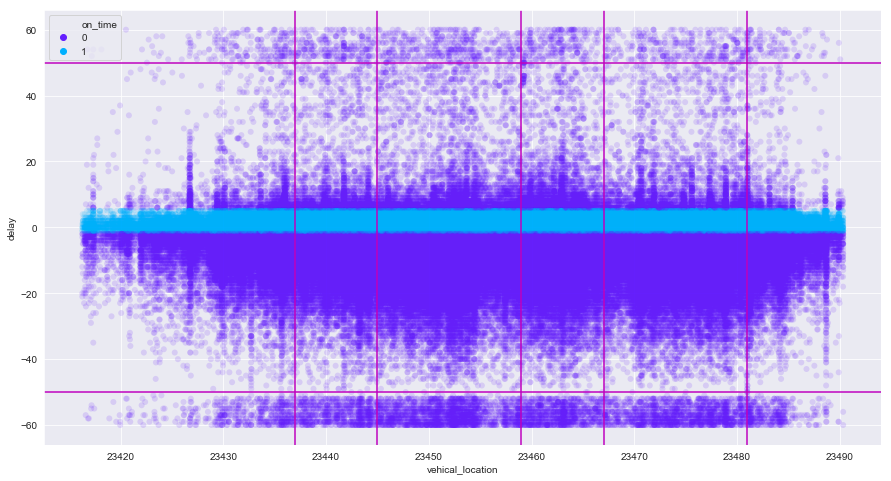

In [42]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='vehical_location', y='delay', hue='on_time',
                linewidth=0, data=bus, alpha=.15)
plt.axvline(x=cent_park, color='m', label='central park')
plt.axvline(x=prosp_park, color='m', label='prospect park')
plt.axvline(x=flushing_mead, color='m', label='flushing meadows')
plt.axvline(x=fordham, color='m', label='fordham')
plt.axvline(x=wagner, color='m', label='wagner college')
plt.axhline(y=-50, color='m')
plt.axhline(y=50, color='m')
plt.show()

In [43]:
bus.loc[(bus['delay'] > 50)|(bus['delay'] < -50)]

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,on_time,boro,boro_code,express,sbs,bus_code,date,vehical_location,destination_location,origin_location
1017,2017-06-01 00:13:00,1,M15,E 126 ST/2 AV,40.803230,-73.932449,SOUTH FERRY via 2 AV,40.701611,-74.012230,5638,...,0,3 - manhattan,2,0,0,109,2017-06-01,23452.270662,23452.277750,23470.648951
3446,2017-06-01 00:53:00,1,Q20A,COLLEGE PT BL/15 AV,40.784073,-73.845894,JAMAICA MERRICK BL via 20 AV via MAIN S,40.704933,-73.793320,7401,...,0,4 - queens,3,0,0,145,2017-06-01,23466.938205,23453.094620,23467.287246
3499,2017-06-01 00:52:00,0,X1,ELTINGVILLE/TRANSIT CENTER,40.560760,-74.171089,W MDTWN CNTRL PK S. via CHURCH via 6 AV,40.766006,-73.976807,2592,...,0,x-express,5,1,0,205,2017-06-01,23463.882034,23463.904273,23426.765711
3528,2017-06-01 00:53:00,0,Q55,PALMETTO ST/WYCKOFF AV,40.700466,-73.909988,RICHMOND HILL JAMAICA AV via MYRTLE AV,40.700150,-73.832466,7276,...,0,4 - queens,3,0,0,164,2017-06-01,23452.188910,23452.194534,23452.173892
3548,2017-06-01 00:53:00,0,B6,HARWAY AV/BAY 37 ST,40.593510,-73.993996,EAST NY NEW LOTS STA,40.666420,-73.883385,7162,...,0,1 - brooklyn,0,0,0,36,2017-06-01,23439.168070,23446.072215,23432.837804
3613,2017-06-01 00:53:00,1,M7,W 146 ST/MALCOLM X BL,40.821152,-73.935974,14 ST via COLUMBUS via 7 AV,40.737411,-73.996696,3898,...,0,3 - manhattan,2,0,0,129,2017-06-01,23467.720551,23458.737284,23473.871386
3659,2017-06-01 00:53:00,1,B61,SMITH ST/FULTON ST,40.691208,-73.987373,PARK SLOPE 20 ST via RED HOOK,40.657574,-73.982948,347,...,0,1 - brooklyn,0,0,0,38,2017-06-01,23444.950026,23444.380372,23450.430067
6971,2017-06-01 02:54:00,0,Bx24,MARCONI ST/911 CALL CENTER,40.855099,-73.837730,PELHAM BAY STATION,40.852577,-73.827362,4089,...,0,2 - bronx,1,0,0,69,2017-06-01,23479.867313,23479.636498,23480.080090
7280,2017-06-01 03:13:00,1,X1,CENTRAL PARK S/6 AV,40.766315,-73.977493,ELTNGVLE TRANST CTR via HYLAN BL RICH AV,40.560837,-74.171120,2513,...,0,x-express,5,1,0,205,2017-06-01,23426.744919,23426.779540,23463.959207
7340,2017-06-01 03:14:00,0,B12,PARKSIDE AV/OCEAN AV,40.654888,-73.961723,EAST NY ALABAMA AV,40.676819,-73.899658,4851,...,0,1 - brooklyn,0,0,0,2,2017-06-01,23447.935260,23447.927762,23443.918117


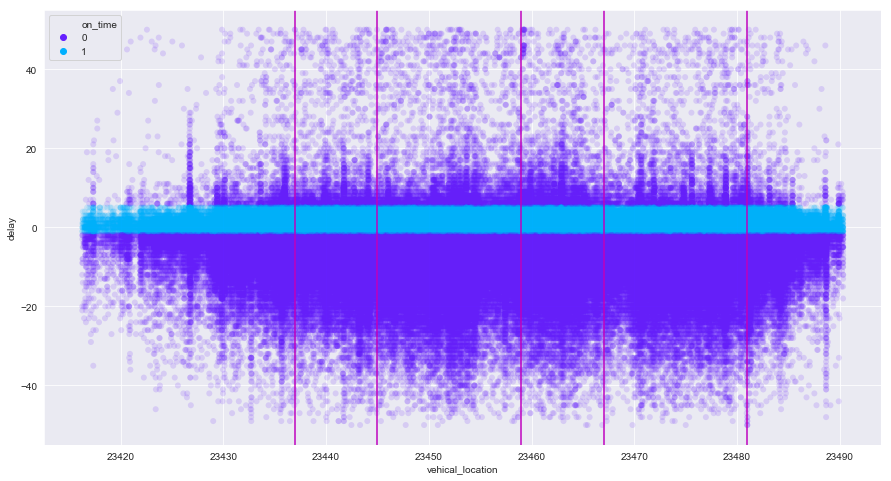

In [44]:
bus = bus.drop(bus[bus['delay']>50].index)
bus = bus.drop(bus[bus['delay']<-50].index)

plt.figure(figsize=(15,8))
sns.scatterplot(x='vehical_location', y='delay', hue='on_time',
                linewidth=0, data=bus, alpha=.15)
plt.axvline(x=cent_park, color='m')
plt.axvline(x=prosp_park, color='m')
plt.axvline(x=flushing_mead, color='m')
plt.axvline(x=fordham, color='m')
plt.axvline(x=wagner, color='m')
plt.show()

In [45]:
bus.shape

(638269, 29)

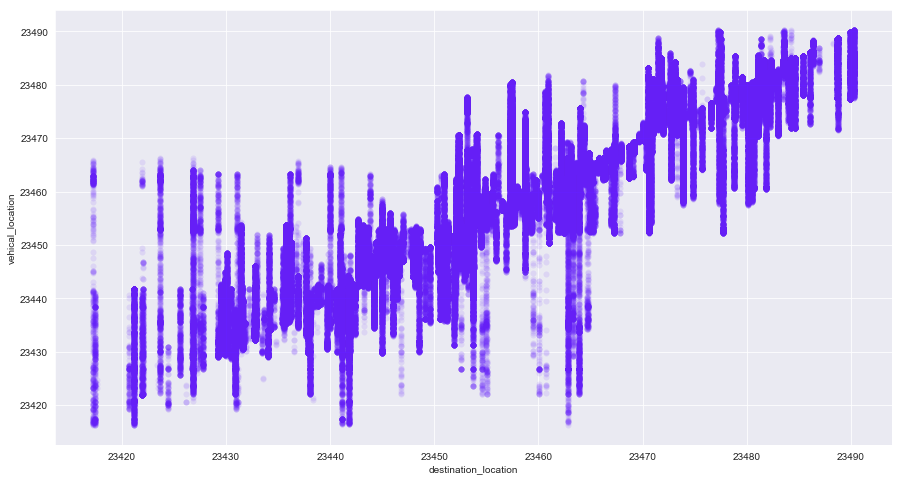

In [46]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='destination_location', y='vehical_location',
                linewidth=0, data=bus.loc[bus.on_time==0], alpha=.1)
plt.show()

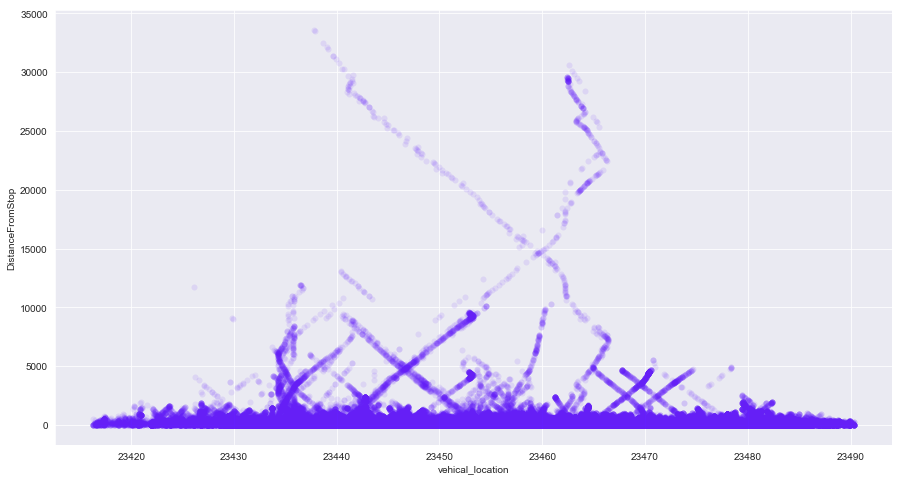

In [47]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='vehical_location', y='DistanceFromStop',
                linewidth=0, data=bus.loc[bus.on_time==0], alpha=.1)
plt.show()

In [48]:
bus.columns

Index(['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation.Latitude',
       'VehicleLocation.Longitude', 'NextStopPointName',
       'ArrivalProximityText', 'DistanceFromStop', 'ExpectedArrivalTime',
       'ScheduledArrivalTime', 'day_of_week', 'delay', 'on_time', 'boro',
       'boro_code', 'express', 'sbs', 'bus_code', 'date', 'vehical_location',
       'destination_location', 'origin_location'],
      dtype='object')

In [49]:
bus[['RecordedAtTime','PublishedLineName','OriginName','DestinationName','NextStopPointName','DistanceFromStop',
     'delay','on_time']].loc[(bus['DistanceFromStop']>31000)&(bus.on_time==0)]

,RecordedAtTime,PublishedLineName,OriginName,DestinationName,NextStopPointName,DistanceFromStop,delay,on_time
73748,2017-06-01 09:53:00,X17J,WOODROW RD/VINELAND AV,E MIDTOWN 57 ST via N JERSEY via MADISON,W 34 ST/9 AV,33605,-9.0,0
277995,2017-06-02 07:05:00,X17J,WOODROW RD/VINELAND AV,E MIDTOWN 57 ST via N JERSEY via MADISON,W 34 ST/9 AV,33460,7.0,0
280958,2017-06-02 07:15:00,X17J,WOODROW RD/VINELAND AV,E MIDTOWN 57 ST via N JERSEY via MADISON,W 34 ST/9 AV,31392,8.0,0
825388,2017-06-05 05:00:00,X17J,WOODROW RD/VINELAND AV,E MIDTOWN 57 ST via N JERSEY via MADISON,W 34 ST/9 AV,32119,-6.0,0
839278,2017-06-05 06:50:00,X17J,WOODROW RD/VINELAND AV,E MIDTOWN 57 ST via N JERSEY via MADISON,W 34 ST/9 AV,31939,-4.0,0
845888,2017-06-05 07:10:00,X17J,WOODROW RD/VINELAND AV,E MIDTOWN 57 ST via N JERSEY via MADISON,W 34 ST/9 AV,31405,6.0,0
864557,2017-06-05 08:10:00,X17J,WOODROW RD/VINELAND AV,E MIDTOWN 57 ST via N JERSEY via MADISON,W 34 ST/9 AV,32475,7.0,0
877009,2017-06-05 08:50:00,X17J,WOODROW RD/VINELAND AV,E MIDTOWN 57 ST via N JERSEY via MADISON,W 34 ST/9 AV,31116,7.0,0


In [50]:
bus.DestinationName.value_counts().head()

WASHINGTON HTS GW BRIDGE                   9256
ST GEORGE FERRY                            6037
FLUSHING  MAIN ST STA                      5743
W FARMS RD SOUTHERN BL                     4868
SELECT BUS SERVICE SOUTH FERRY via 2 AV    4756
Name: DestinationName, dtype: int64

In [51]:
bus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 638269 entries, 1 to 1048573
Data columns (total 29 columns):
RecordedAtTime               638269 non-null datetime64[ns]
DirectionRef                 638269 non-null int64
PublishedLineName            638269 non-null category
OriginName                   638269 non-null object
OriginLat                    638269 non-null float64
OriginLong                   638269 non-null float64
DestinationName              638269 non-null object
DestinationLat               638269 non-null float64
DestinationLong              638269 non-null float64
VehicleRef                   638269 non-null int64
VehicleLocation.Latitude     638269 non-null float64
VehicleLocation.Longitude    638269 non-null float64
NextStopPointName            638269 non-null object
ArrivalProximityText         638269 non-null object
DistanceFromStop             638269 non-null int64
ExpectedArrivalTime          638269 non-null float64
ScheduledArrivalTime         638269 non-nu

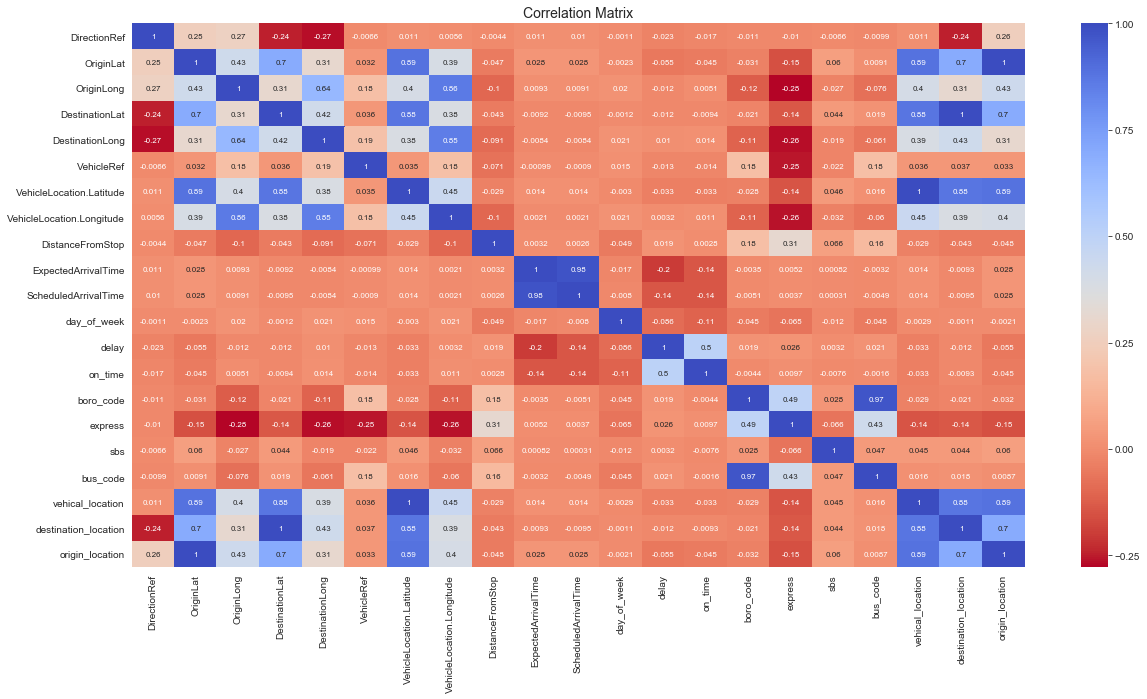

In [52]:
plt.figure(figsize=(20,10))
sample_corr = bus.corr()
sns.heatmap(sample_corr, cmap='coolwarm_r', annot=True, annot_kws={'size':8})
plt.title('Correlation Matrix', fontsize=14)
plt.show()

### Balance the Data

In [53]:
compare = pd.DataFrame()

compare['On Time'] = bus.on_time.loc[bus['on_time']==1].describe()
compare['Not On Time'] = bus.on_time.loc[bus['on_time']==0].describe()

compare

,On Time,Not On Time
count,264101.0,374168.0
mean,1.0,0.0
std,0.0,0.0
min,1.0,0.0
25%,1.0,0.0
50%,1.0,0.0
75%,1.0,0.0
max,1.0,0.0


In [55]:
bus_s = bus.sample(frac=1, random_state=40)

ontime = bus_s.loc[bus['on_time']==1][:264101]
offtime = bus_s.loc[bus['on_time']==0][:264101]

bus = pd.concat([ontime, offtime])
bus = bus.sample(frac=1, random_state=40)

compare['On Time'] = bus.on_time.loc[bus['on_time']==1].describe()
compare['Not On Time'] = bus.on_time.loc[bus['on_time']==0].describe()
compare

,On Time,Not On Time
count,264101.0,264101.0
mean,1.0,0.0
std,0.0,0.0
min,1.0,0.0
25%,1.0,0.0
50%,1.0,0.0
75%,1.0,0.0
max,1.0,0.0


## Modeling

In [58]:
from sklearn.feature_selection import SelectKBest, f_classif

X = bus.drop(['RecordedAtTime', 'PublishedLineName', 'OriginName','DestinationName', 'NextStopPointName',
              'ArrivalProximityText','boro','date','ExpectedArrivalTime', 'delay','on_time'], 1)
y = bus['on_time']

selector=SelectKBest(score_func=f_classif,k=18)
selector.fit(X,y)
scores = pd.DataFrame()
scores["Attribute"] = X.columns
scores["F Score"] = selector.scores_
scores["P Value"] = selector.pvalues_
scores["Support"] = selector.get_support()

scores = scores.sort_values(by=['F Score'], ascending=False)

key_vals = scores.Attribute.head(8).values

scores

,Attribute,F Score,P Value,Support
9,ScheduledArrivalTime,11204.445874,0.000000e+00,True
10,day_of_week,6402.150473,0.000000e+00,True
1,OriginLat,1119.517294,3.425050e-245,True
17,origin_location,1112.368909,1.216275e-243,True
6,VehicleLocation.Latitude,612.128313,4.603107e-135,True
15,vehical_location,606.713563,6.908995e-134,True
0,DirectionRef,181.144476,2.769215e-41,True
4,DestinationLong,119.593141,7.819813e-28,True
5,VehicleRef,114.332188,1.109050e-26,True
7,VehicleLocation.Longitude,64.042554,1.220045e-15,True


In [59]:
X = bus[key_vals]
y = bus['on_time']

#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler.fit(X,y)

#X = StandardScaler().fit_transform(X)
#y = StandardScaler().fit_transform(y)

# to split a training and test sample
from sklearn.model_selection import train_test_split, cross_val_score
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Logistic Regression

In [60]:
# How long will it take
from datetime import datetime
start_time = datetime.now()

# get rid of the warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1e9, max_iter = 150)
lr.fit(x_train, y_train)

# Set Up Predictor
ypred_lr = lr.predict(x_test)

print('Train Percentage accuracy:')
print(lr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(lr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(lr, x_train, y_train, cv = 5))

from sklearn.metrics import classification_report
print('\nClassification Report:\n')
print(classification_report(y_test, ypred_lr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

Train Percentage accuracy:
0.5760480220925859

Test Percentage accuracy:
0.5752020052858365

Cross Validation:
[0.57613813 0.57803133 0.57530512 0.57468856 0.57645559]

Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.55      0.57     66008
           1       0.57      0.60      0.58     66043

   micro avg       0.58      0.58      0.58    132051
   macro avg       0.58      0.58      0.58    132051
weighted avg       0.58      0.58      0.58    132051


Duration: 0:00:07.356382


In [61]:
start_time = datetime.now()
# get rid of the warnings
import warnings
warnings.filterwarnings("ignore")

# Grid Search CV for decision tree
from sklearn.model_selection import GridSearchCV

#GridSearchCV for random forest 
param_grid = {'C':[1e9,.5,1,3], 'max_iter':[25,50,100], 'penalty':['l1','l2']}

# Start the grid search again
grid_DT = GridSearchCV(lr, param_grid, cv=3, verbose=1, n_jobs=-1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:')
print(grid_DT.best_params_)

# Set Up Predictor
ypred_lr = lr.predict(x_test)

from sklearn.metrics import classification_report
print('\nClassification Report:\n')
print(classification_report(y_test, ypred_lr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 31.6min finished


Best score for data:
{'C': 1000000000.0, 'max_iter': 25, 'penalty': 'l2'}

Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.55      0.57     66008
           1       0.57      0.60      0.58     66043

   micro avg       0.58      0.58      0.58    132051
   macro avg       0.58      0.58      0.58    132051
weighted avg       0.58      0.58      0.58    132051


Duration: 0:31:37.785129


### Naive Bayes

In [62]:
start_time = datetime.now()

from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(x_train, y_train)
# Set Up Predictor
ypred_bnb = bnb.predict(x_test)

print('\nTrain Percentage accuracy:')
print(bnb.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(bnb.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(bnb, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_bnb))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.5348288910036829

Test Percentage accuracy:
0.5347176469697313

Cross Validation:
[0.53534601 0.53664601 0.53397029 0.53409736 0.53408474]

Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.84      0.64     66008
           1       0.59      0.23      0.33     66043

   micro avg       0.53      0.53      0.53    132051
   macro avg       0.56      0.53      0.49    132051
weighted avg       0.56      0.53      0.49    132051


Duration: 0:00:00.970423


### K Nearest Neighbors

In [63]:
start_time = datetime.now()

from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=30)
knn.fit(x_train, y_train)
# Set Up Predictor
ypred_knn = knn.predict(x_test)

print('\nTrain Percentage accuracy:')
print(knn.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(knn.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(knn, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_knn))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.73703209129852

Test Percentage accuracy:
0.7086428728294372

Cross Validation:
[0.69857758 0.70137951 0.69904457 0.69820394 0.69891075]

Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.72      0.71     66008
           1       0.71      0.70      0.71     66043

   micro avg       0.71      0.71      0.71    132051
   macro avg       0.71      0.71      0.71    132051
weighted avg       0.71      0.71      0.71    132051


Duration: 0:00:38.033273


### Decision Tree

In [64]:
start_time = datetime.now()
from sklearn import tree

dec_tr = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=20,
    random_state = 1337
)

dec_tr.fit(x_train, y_train)
# Set Up Predictor
ypred_dec_tr = dec_tr.predict(x_test)

print('\nTrain Percentage accuracy:')
print(dec_tr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(dec_tr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(dec_tr, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_dec_tr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.7429237841126237

Test Percentage accuracy:
0.6240391969769256

Cross Validation:
[0.61070793 0.61782636 0.62172634 0.61702155 0.61469916]

Classification Report:

              precision    recall  f1-score   support

           0       0.62      0.64      0.63     66008
           1       0.63      0.61      0.62     66043

   micro avg       0.62      0.62      0.62    132051
   macro avg       0.62      0.62      0.62    132051
weighted avg       0.62      0.62      0.62    132051


Duration: 0:00:03.881931


### Gradient Boosted Decision Tree

In [65]:
start_time = datetime.now()
from sklearn import ensemble

clf = ensemble.GradientBoostingClassifier(loss='exponential', max_depth=8 , n_estimators=50 )
clf.fit(x_train, y_train)

ypred_clf = clf.predict(x_test)

print('\nTrain Percentage accuracy:')
print(clf.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(clf.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(clf, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_clf))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.7269223099272752

Test Percentage accuracy:
0.7168291039068239

Cross Validation:
[0.7113756  0.7165882  0.71286491 0.71278194 0.71395575]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.75      0.72     66008
           1       0.73      0.69      0.71     66043

   micro avg       0.72      0.72      0.72    132051
   macro avg       0.72      0.72      0.72    132051
weighted avg       0.72      0.72      0.72    132051


Duration: 0:08:16.136331


### Random Forest

In [66]:
start_time = datetime.now()
rfc = ensemble.RandomForestClassifier(n_estimators=50, max_depth=8)
rfc.fit(x_train, y_train)

ypred_rfc = rfc.predict(x_test)

print('\nTrain Percentage accuracy:')
print(rfc.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(rfc.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(rfc, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_rfc))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.6194380425645777

Test Percentage accuracy:
0.6152774306896578

Cross Validation:
[0.61744772 0.61913897 0.61908849 0.61503995 0.61549433]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.61      0.61     66008
           1       0.61      0.62      0.62     66043

   micro avg       0.62      0.62      0.62    132051
   macro avg       0.62      0.62      0.62    132051
weighted avg       0.62      0.62      0.62    132051


Duration: 0:01:30.468725


### Support Vector Machines

In [ ]:
from sklearn.svm import SVC

svc = SVC(kernel = 'linear')
svc.fit(x_train, y_train)
ypred_svc = svc.predict(x_test)

print('\nTrain Percentage accuracy:')
print(svc.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(svc.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(svc, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_svc))